# 3D Tag Signal Processing

In [1]:
import pickle
import numpy as np
import glob
import pickle
import matplotlib
import matplotlib.backends.backend_tkagg
#from mmetro_v7 import Mmetro_Utils
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.stats as stats
import random
import matplotlib.animation as animation
import scipy as scipy

def hanning(M, *varargin):
    m = np.linspace(-(M-1)/2,(M-1)/2,M)  
    Win = 0.5 + 0.5*np.cos(2*np.pi*m/M)
    if len(varargin) > 0:
        N = varargin[0]
        Win = np.broadcast_to(Win,(N,M)).T
    return Win

# Range Profile/Doppler FFT functions

In [2]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def get_RP(data, frame_size, N, freq_min, freq_max, nfft=2**8, fs=1e6, bg_sub=True):
    # reshape the data
    data = np.reshape(data, (N, frame_size), order='F')
    # background subtraction
    if bg_sub:
        data = data - data[:,0][:,None]

    # normalization
    for i in range(data.shape[1]):
        data[:,i] = data[:,i] - data[:,i].mean()

    # hanning window used for getting RP
    Win2D = hanning(N, int(frame_size))

    RP = signal.zoom_fft(np.multiply(data, Win2D), fn=[freq_min,freq_max], m=nfft, axis=0, fs=fs)
    return RP

def get_RD(RP, frame_size, nfft):
    WinVel2D = hanning(int(frame_size), nfft)
    WinVel2D = WinVel2D.transpose()

    # getting RD
    RPExt = RP
    RPExt = RPExt - np.mean(RPExt, axis=1)[:,np.newaxis]
    RD = np.fft.fft(np.multiply(RPExt, WinVel2D), n=nfft, axis=1)
    RD = np.fft.fftshift(RD, axes=(1,))
    RD[:,116:140] = 0 # removing middle doppler noise
    return RD
    
# not working
def angle_fft(RP_cube, nfft, d_over_lambda=0.5, window=np.hanning):
    """
    RD_cube : (R, D, N_rx)
    returns
        theta      : (Nfft_ang,) angle grid in radians
        P_ang_cube : (R, D, Nfft_ang) power spectrum
    """
    R, D, N_rx = RP_cube.shape
    w = window(N_rx)                            # spatial window                        # broadcast
    AoA = np.fft.fftshift(
            np.fft.fft(RP_cube * w, n=nfft, axis=2), axes=2)
    AoA_db = 20.0 * np.log10(np.abs(AoA) + 1e-12)
    AoA_norm = AoA_db - AoA_db.max()
    AoA_norm[AoA_norm < -25.0] = -25.0
    AoA_norm = AoA_norm.max(axis=1)
    # # P = np.abs(AoA) ** 2

    # u = (np.arange(nfft) - nfft/2) / nfft
    # theta = np.arcsin(u / d_over_lambda)        # radians
    # WinAnt2D = hanning(int(N_rx), nfft)
    # # sca_win_ant = WinAnt2D.sum()
    # WinAnt2D = WinAnt2D.transpose()
    # j_opt = np.fft.fftshift(np.fft.fft(RP_cube * WinAnt2D, n=nfft, axis=2) / sca_win_ant, axes=2)
    # j_db = 20.0 * np.log10(np.abs(j_opt) + 1e-12)
    # j_norm = j_db - j_db.max()
    # j_norm[j_norm < -25.0] = -25.0
    # j_norm = j_norm.max(axis=1)  # collapse chirp dimension
    return AoA_norm

# Template matching for sinc pattern in RD 
def generate_template(period, frame_size, f_tag, nfft=2**8, tag_duty_cycle=0.5):
    # period = Tc (chrip time)
    # frame size = Nc (#chirps in a frame)
    # nfft = 256 = Ns (number of samples, also the number of points in the FFT)

    # generating a time vector with values for each chirp (period)
    t = np.arange(0, period*frame_size, period)

    # generating a square wave during that time with the given duty cycle 
    sq_wav = signal.square(2*np.pi*f_tag*t, tag_duty_cycle)

    # the template is the FFT of the square wave
    sq_wav_fft = np.fft.fftshift(np.fft.fft(sq_wav, n=nfft, axis=0))
    return sq_wav_fft


def get_range(frame_idx, data_raw, antenna_pick, frame_size, N, chirp_slope, period, range_min, range_max, f_tag, fs=1e6, nfft=2**8):
    data_single_chn = data_raw[:,:,antenna_pick] # select one channel (antena)
    data_snapshot = data_single_chn[:,frame_idx] # select the frame

    # define frequency max and min
    freq_min = 2*range_min * chirp_slope / c
    freq_max = 2*range_max * chirp_slope / c
    
    # get the range profile 
    RP = get_RP(data=data_snapshot, \
                frame_size=frame_size, 
                N=N, 
                freq_min=freq_min, 
                freq_max=freq_max, 
                nfft=nfft,
                fs=fs,
                bg_sub=True)

    # get the range-doppler
    RD = get_RD(RP, frame_size=frame_size, nfft=nfft)

    # Template matching code
    # 400 is the number of frequency steps 
    csweep = np.zeros(400)
    corr_240 = 0
    corr_332 = 0
    for fstep in range(0,400):
        # generate the template for fstep'th frequency step 
        template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=fstep)

        # bunch of stuff happening here, but basically applying the template (currently (N,)) through the entire range axis and then taking dot product with the RD
        # template[:, np.newaxis]                                  --> changes shape from (N,) to (N,1)
        # np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1) --> copies the template in all the range bins 
        correlation = np.sum(np.abs(RD) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1)
        
        # stores the max value for that frequency 
        csweep[fstep] = np.max(correlation)
    
    # Trying to locate the tag -- get indexes for the tags
    # --- why 4 faces? Top face and face D share the same control signal 
    f_tags = [183, 337, 250, 127]
    max_idxs = np.zeros(4)
    for i in range(len(f_tags)):
        # generate the template for that particular tag face
        template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])
        correlation = np.sum(np.abs(RD) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

        # -- why are we calculating this in the loop? 
        freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
        range_steps = freq_steps * c / 2 / chirp_slope

        # get the range index of the highest correlation
        max_idxs[i] = np.argmax(correlation)
    return RP, RD, csweep, max_idxs, range_steps

# not working
def get_angle(frame_idx, data_raw, frame_size, N, chirp_slope, period, range_min, range_max, f_tag, fs=1e6, nfft=2**8):
    # data_snapshot = data_raw[:, frame_idx, :]      # (N, N_rx)
    # N_rx = data_snapshot.shape[1]
    # define frequency max and min
    freq_min = 2*range_min * chirp_slope / c
    freq_max = 2*range_max * chirp_slope / c
    # print(freq_min)
    # print(freq_max)
    v_range = np.arange(nfft) / nfft * fs * c / (2 * chirp_slope)
    r_max_idx = np.argmin(np.abs(v_range - range_max))
    v_range_ext = v_range[: r_max_idx + 1]
    r_offset = np.sum(v_range_ext < 0.1)

    RP = np.empty((nfft,nfft, 4), dtype=complex)
    RD = np.empty((nfft,nfft, 4), dtype=complex)
    for ant in range(4):
        data_single_chn = data_raw[:,:,ant] # select one channel (antena)
        data_snapshot = data_single_chn[:,frame_idx] # select the frame
        RPExt = get_RP(data=data_snapshot,
            frame_size=frame_size, 
            N=N, 
            freq_min=freq_min, 
            freq_max=freq_max, 
            nfft=nfft,
            fs=fs,
            bg_sub=True)
        
        RP[:,:,ant] = RPExt #- np.mean(RPExt, axis=1)[:,np.newaxis]
        # RPExt = RPExt - np.mean(RPExt, axis=1)[:,np.newaxis]
        # RP[:,:,ant] = RPExt[r_offset : r_max_idx + 2,:]
        # RD_temp = get_RD(RPExt, frame_size, nfft)
        # RD[:, :, ant] = RD_temp
    # RD = np.empty((RP.shape[0], nfft, 4), dtype=complex)

    AoA = angle_fft(RP, nfft=nfft)
    # freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    # range_steps = freq_steps * c / 2 / chirp_slope
    return AoA # theta_grid, P_ang, range_steps
        

    

# Frame by Frame Animation

(256, 256)
137
range: 1.0745098039215686
(array([  1,   5,  10,  12,  15,  18,  20,  22,  26,  30,  33,  38,  41,
        45,  49,  51,  56,  59,  63,  67,  71,  78,  81,  85,  88,  92,
        96, 100, 103, 108, 114, 142, 148, 153, 156, 160, 164, 169, 171,
       177, 180, 183, 189, 193, 195, 200, 204, 206, 211, 213, 215, 218,
       226, 228, 230, 236, 238, 241, 246, 249]), {})
[148 108]
[294.53125 255.46875]


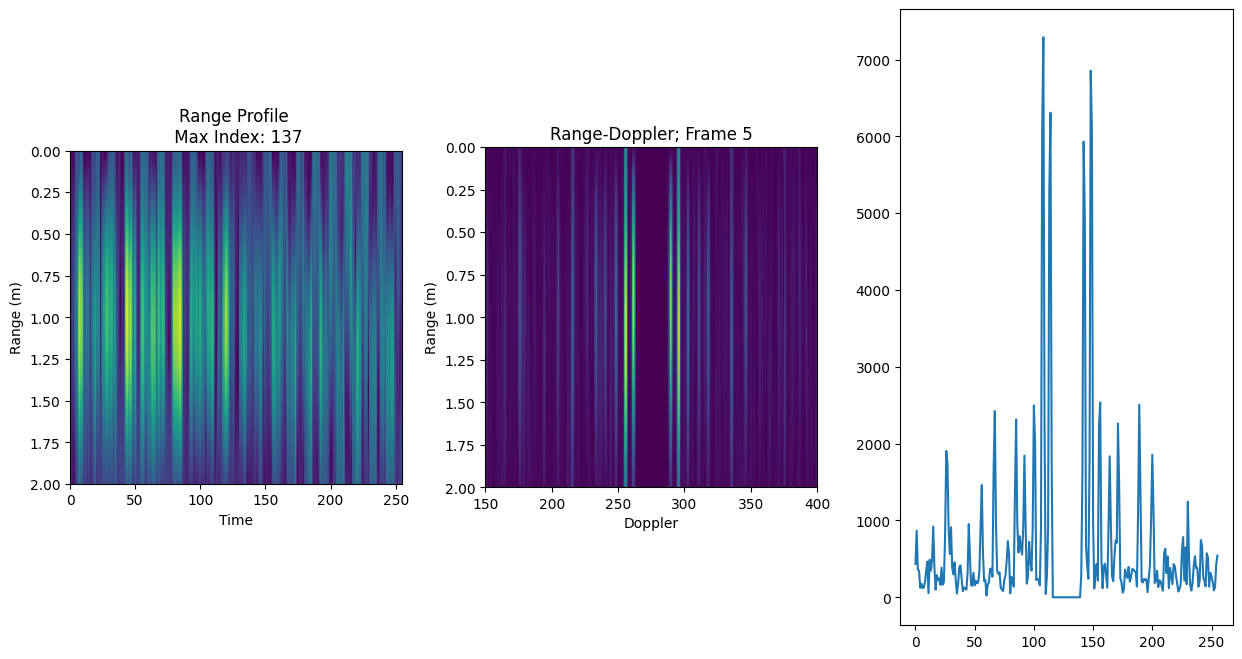

In [5]:
# %matplotlib ipympl
data_raw = pickle.load(open('straight_100cm_V-24GHz.pickle', 'rb'))
# data_raw = pickle.load(open('test_static_aoa_45-24Ghz.pickle', 'rb'))


antenna_pick = 1
nfft = 2**8
fs = 1e6
c = 2.98e8
range_min = 0
range_max = 2
dop_spacing = 2         # Hz, from music code
doppler_min = 150 
doppler_max = 400       # don't know why I'm using them -- from MUSIC code  

# -- is f_tag the switching frequency? 
f_tag = 500

cfg = data_raw['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']

data_signal_raw = data_raw['Data']
# n_frames = data_signal_raw.shape[1]
n_frames = 50

# -- what's dopwidth? 
dopwidth = 80
grid1 = np.zeros((dopwidth, n_frames))
grid2 = np.zeros((dopwidth, n_frames))
dopgrid = np.zeros((nfft,n_frames))

# Initialize plot
# fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, figsize=(14, 9))
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 8))
plt.subplots_adjust(hspace= 0.5, wspace = 0.25)

def animate(frame):
    # Call get_range and return computed RP, RD, csweep
    RP, RD, csweep, max_idxs, range_steps = get_range(
        frame_idx = frame,
        data_raw=data_signal_raw,
        antenna_pick=antenna_pick,
        frame_size=frame_size,
        N=N,
        chirp_slope=chirp_slope,
        period=period,
        range_min=range_min,
        range_max=range_max,
        f_tag=f_tag,
        fs=fs,
        nfft=nfft
    )
    print(RP.shape)
    max_idx = int(max_idxs[0])
    print(max_idx)
    print("range: " + str(range_steps[max_idx]))
    # Clear previous frame
    ax1.clear()
    ax2.clear()
    ax3.clear()
    # ax4.clear()
    # ax7.clear()
    # ax8.clear()
    # ax6.clear()
    # ax4.clear()

    # Update subplots
    # NOTE: change the RD titles 
    # why do the other faces' frequencies not appear in this? were they turned off? 
    ax1.set_title("Range Profile \n Max Index: " + str(max_idx))
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Range (m)")
    ax1.imshow(np.abs(RP),extent=[0, 255, range_max, range_min], aspect=128)      # extent = [left, right, bottom, top]
    ax2.set_title("Range-Doppler; Frame " + str(frame))
    ax2.set_ylabel("Range (m)")
    ax2.set_xlabel("Doppler")
    ax2.imshow(np.abs(RD), extent=[doppler_min, doppler_max, range_max, range_min], aspect=128)

    ax3.plot(np.abs(RD[max_idx]))
    peaks = scipy.signal.find_peaks(np.abs(RD[max_idx]))
    print(peaks)
    
    top_2_peaks = np.argpartition(np.abs(RD[max_idx]),-2)[-2:]
    print(top_2_peaks)
    # 114, 142 --> peaks
    # find the doppler frequncies for those peaks
    dopp_freqs = np.arange(start = doppler_min, stop = doppler_max, step = (doppler_max - doppler_min) / RD.shape[1])
    print(dopp_freqs[top_2_peaks])

    # ax6.set_xticks(np.arange(0, 400, 50))
    # ax6.set_xlim(100, 400)
    # ax6.set_ylim(0, 1.2 * np.max(csweep[100:]))
    # # ax6.set_ylim(0, 9*10**7)
    # # ax6.set_title("Max correlation value\n for each frequency")
    # ax6.set_xlabel("Mod Freq (Hz)")
    # ax6.plot(csweep)  # --- this gives us the 183 Hz peak right?

    # searching for tag doppler bins
    # modbinsleft = np.argsort(np.abs(RD[max_idx,0:120]))
    # modbinsright = np.argsort(np.abs(RD[max_idx,140:])) + 140 
    # mbl1 = modbinsleft[-2]
    # mbl2 = modbinsleft[-1]
    # mbr1 = modbinsright[-2]
    # mbr2 = modbinsright[-1]
    # print(mbl1)
    # print(mbr1)
    # modbinleft= np.argmax(np.abs(RD[max_idx,0:120]))
    # modbinright= np.argmax(np.abs(RD[max_idx,140:])) + 140
    
    # hardcode doppler bin selection
    #127 Hz: 113, 143
    #183 Hz: 
    #250 Hz: 101, 155
    #337 Hz: 90, 166
    # side1 = 1
    # side2 = 2
    
    # # -- why are there only 4 modulation frequencies? are we not considering the front side?
    # modfreqs = [127, 183, 250, 337]
    # modfreq1 = modfreqs[side1]
    # modfreq2 = modfreqs[side2]

    # binsleft = [113, 106, 101, 90]
    # binsright = [144, 150, 155,166]
    # mbl1 = binsleft[side1]
    # mbr1 = binsright[side1]
    # mbl2 = binsleft[side2]
    # mbr2 = binsright[side2]

    # # ax4.set_ylim(-200,200)
    # # --- What's rdbinleft/right?
    # rdbinleft = RD[(max_idx-int(dopwidth/2)):(max_idx+int(dopwidth/2)), mbl1]
    # rdbinright = RD[(max_idx-int(dopwidth/2)):(max_idx+int(dopwidth/2)), mbr1]
    # I_tag = (rdbinright + np.conjugate(rdbinleft))/2
    # F_tag = (rdbinright - np.conjugate(rdbinleft))*1j/2

    # phase_idx1 = str(np.argmin(np.abs(I_tag)))
    # phase = (np.atan(I_tag/F_tag))
    # ax3.set_title("Phase of RD at \nEstimated Range \nMod Freq: " + str(modfreq1) + " Hz")
    # ax3.plot(np.linspace(0,1,dopwidth),phase)
    # # ax4.plot(np.linspace(0,1,40),180*np.unwrap(np.angle(RD[(max_idx-20):(max_idx+20), modbin]))/np.pi)

    # ax7.set_title("I Component of RD at \nEstimated Range \nMod Freq: " + str(modfreq1) + " Hz " + "Index: " + phase_idx1)
    # ax7.plot(np.abs(I_tag))

    # grid1[:,frame] = np.abs(normalize(I_tag))

    # rdbinleft = RD[(max_idx-int(dopwidth/2)):(max_idx+int(dopwidth/2)), mbl2]
    # rdbinright = RD[(max_idx-int(dopwidth/2)):(max_idx+int(dopwidth/2)), mbr2]
    # I_tag = (rdbinright + np.conjugate(rdbinleft))/2
    # phase_idx2 = str(np.argmin(np.abs(I_tag)))
    # F_tag = (rdbinright - np.conjugate(rdbinleft))*1j/2
    # phase = (np.atan(I_tag/F_tag))
    
    # ax4.set_title("Phase of RD at \nEstimated Range \nMod Freq: " + str(modfreq2) + " Hz")
    # ax4.plot(np.linspace(0,1,dopwidth),phase)
    # # ax4.plot(np.linspace(0,1,40),180*np.unwrap(np.angle(RD[(max_idx-20):(max_idx+20), modbin]))/np.pi)

    # ax8.set_title("I Component of RD at \nEstimated Range \nMod Freq: " + str(modfreq2) + " Hz " + "Index: " + phase_idx2)
    # ax8.plot(np.abs(I_tag))

    # grid2[:,frame] = np.abs(normalize(I_tag))

    # # what's this about? 
    # dopgrid[:,frame] = normalize(np.abs(RD))[max_idx]
    # ax10.set_title("RD over frames")
    # ax10.set_xlabel("Frame number")
    # ax10.set_ylim(75, 175)
    # ax10.set_ylabel("RD")
    # ax10.imshow(dopgrid, aspect='auto')

    # ax11.set_title("I Component over Frames \nMod Freq: " + str(modfreq1) + " Hz")
    # ax11.set_xlabel("Frame number")
    # ax11.set_ylabel("I signal")
    # ax11.imshow(grid1, aspect='auto')

    # ax12.set_title("I Component over Frames \nMod Freq: " + str(modfreq2) + " Hz")
    # ax12.set_xlabel("Frame number")
    # ax12.set_ylabel("I signal")
    # ax12.imshow(grid2, aspect='auto')

# plt.ion()

animate(5)
# ani = animation.FuncAnimation(fig, animate, frames=n_frames, interval=250, repeat=False)
# plt.show()


# Microdisplacement processing (Mainly using this lately)

## Microdisplacment helper function

In [4]:
# what does this do? 
def get_period(Igrid, Fgrid):
    freqIndex = []
    for frameIdx in range(n_frames):
        Ipeaks, _ = signal.find_peaks((Igrid[:,frameIdx]))
        Fpeaks, _ = signal.find_peaks((Fgrid[:,frameIdx]))
        # print("peaks: " + str(Ipeaks))
        per1temp = np.diff(Ipeaks)
        per2temp = np.diff(Fpeaks)

        freqIndex.extend(per1temp)
        freqIndex.extend(per2temp)

    # Calculate period using a trimmed mean (similar to MATLAB's trimmean)
    if len(freqIndex) > 0:
        period = stats.trim_mean(freqIndex, 0.1)  # 10% trim on both ends
    else:
        period = 0  # Handle case where no peaks are found
    return period

# Unwrap phases and compute unwrapped distance
def unwrapPi(phases):
    # Custom phase unwrapping similar to MATLAB's unwrap with pi-periodicity
    return np.unwrap(phases, period=np.pi)

def get_displacement(Igrid, Qgrid):
    phi = np.linspace(0, np.pi, 4001)  # (0 : pi/4000 : pi) -> 4001 points from 0 to pi
    x = np.arange(0, dopwidth)  # x = 1 : size(magFFTAll, 2)
    triWave = np.tile(signal.windows.triang(dopwidth), (n_frames, 1))

    period = get_period(Igrid, Qgrid)

    # Preallocate autocorrelation arrays
    autoCorr2a = np.zeros((n_frames, len(phi)))
    autoCorr2b = np.zeros((n_frames, len(phi)))
    for phiIdx, phiVal in enumerate(phi):
        sinW = np.tile(np.abs(np.sin(x * np.pi / period + phiVal)), (n_frames, 1))
        cosW = np.tile(np.abs(np.cos(x * np.pi / period + phiVal)), (n_frames, 1))
        autoCorr2a[:, phiIdx] = np.sum(normalize(Igrid.transpose()) * sinW * triWave, axis=1)
        autoCorr2b[:, phiIdx] = np.sum(normalize(Qgrid.transpose()) * cosW * triWave, axis=1)
    autocorr = autoCorr2a + autoCorr2b
    # print(autocorr)
    # Find the index of the maximum correlation
    I = np.argmax(autocorr, axis=1)

    # Extract phases
    angles = phi[I]

    lam = c/(24.125e9)
    # for distance in m
    # return (lam / (4 * np.pi)) * unwrapPi(angles) 
    return unwrapPi(angles)

## Data Processing

In [ ]:
# %matplotlib ipympl
data_raw = pickle.load(open('straight_100cm_V-24GHz.pickle', 'rb'))

antenna_pick = 2
nfft = 2**8
fs = 1e6
c = 2.98e8
range_min = 0
range_max = 5
f_tag = 500

cfg = data_raw['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']

data_signal_raw = data_raw['Data']
# n_frames = data_signal_raw.shape[1]
n_frames = 50

dopwidth = 80 #width of doppler
Igrid = np.zeros((4,dopwidth, n_frames))
Qgrid = np.zeros((4,dopwidth, n_frames))
Pgrid = np.zeros((4,dopwidth, n_frames))
dopgrid = np.zeros((nfft, n_frames))

max_idxs = np.zeros(n_frames)
max_idxs2 = np.zeros(n_frames)
max_idxs3 = np.zeros(n_frames)
max_idxs4 = np.zeros(n_frames)

for frame in range(0,n_frames):
    # Call get_range and return computed RP, RD, csweep
    RP, RD, csweep, max_idx, range_steps = get_range(
        frame_idx = frame+2,
        data_raw=data_signal_raw,
        antenna_pick=antenna_pick,
        frame_size=frame_size,
        N=N,
        chirp_slope=chirp_slope,
        period=period,
        range_min=range_min,
        range_max=range_max,
        f_tag=f_tag,
        fs=fs,
        nfft=nfft
    )
    max_idxs[frame] = range_steps[int(max_idx[0])]
    max_idxs2[frame] = range_steps[int(max_idx[1])]
    max_idxs3[frame] = range_steps[int(max_idx[2])]
    max_idxs4[frame] = range_steps[int(max_idx[3])]
    # max_idx[0],max_idx[1],max_idx[2] = 90,90,90
    # Clear previous frame

    # ax1.set_title("Range Doppler (0-5m); Frame " + str(frame))
    # ax1.set_ylabel("Range")
    # ax1.imshow(np.abs(RD), extent=[range_min, range_max, range_max, range_min])

    # searching for tag doppler bins
    # modbinsleft = np.argsort(np.abs(RD[int(max_idx[0]),0:120]))
    # modbinsright = np.argsort(np.abs(RD[int(max_idx[0]),140:])) + 140 
    # mbl1 = modbinsleft[-2]
    # mbl2 = modbinsleft[-1]
    # mbr1 = modbinsright[-2]
    # mbr2 = modbinsright[-1]
    # modbinleft= np.argmax(np.abs(RD[max_idx,0:120]))
    # modbinright= np.argmax(np.abs(RD[max_idx,140:])) + 140
    # print(modbinsleft)
    # print(modbinsright)

    # hardcode doppler bin selection
    #side 0: 127 Hz: 113, 143
    #side 1: 183 Hz: 106, 150
    #side 2: 250 Hz: 101, 155
    #side 3: 337 Hz: 90, 166
    side1 = 1
    side2 = 3
    side3 = 2
    side4 = 0
    
    modfreqs = [127, 183, 250, 337]
    modfreq1 = modfreqs[side1]
    modfreq2 = modfreqs[side2]
    modfreq3 = modfreqs[side3]
    modfreq4 = modfreqs[side4]

    binsleft = [113, 106, 101, 90]
    binsright = [144, 150, 155,166]
    mbl = [0,0,0,0]
    mbr = [0,0,0,0]
    mbl[0] = binsleft[side1]
    mbr[0] = binsright[side1]
    mbl[1] = binsleft[side2]
    mbr[1] = binsright[side2]
    mbl[2] = binsleft[side3]
    mbr[2] = binsright[side3]
    mbl[3] = binsleft[side4]
    mbr[3] = binsright[side4]

    dopgrid[:,frame] = (np.abs(RD))[int(max_idx[1])]
    # ax4.set_ylim(-200,200)
    # print(max_idx[1])
    for i in range(4):
        rdbinleft = RD[(int(max_idx[1])-int(dopwidth/2)):(int(max_idx[1])+int(dopwidth/2)), mbl[i]]
        rdbinright = RD[(int(max_idx[1])-int(dopwidth/2)):(int(max_idx[1])+int(dopwidth/2)), mbr[i]]
        I_tag = (rdbinright + np.conjugate(rdbinleft))/2
        Q_tag = (rdbinright - np.conjugate(rdbinleft))*1j/2

        # phase_idx1 = str(np.argmin(np.abs(I_tag)))
        phase = np.atan(I_tag/Q_tag) #play around with this

        Igrid[i][:,frame] = normalize(np.abs((I_tag)))
        Qgrid[i][:,frame] = normalize(np.abs((Q_tag)))
        Pgrid[i][:,frame] = normalize(np.abs(phase))

    # dopgrid[:,frame] = normalize(dopgrid[:,frame])

unwrappedDist = get_displacement(Igrid[0], Qgrid[0])
unwrappedDist2 = get_displacement(Igrid[1], Qgrid[1])
unwrappedDist3 = get_displacement(Igrid[2], Qgrid[2])
unwrappedDist4 = get_displacement(Igrid[3], Qgrid[3])

## Plotting

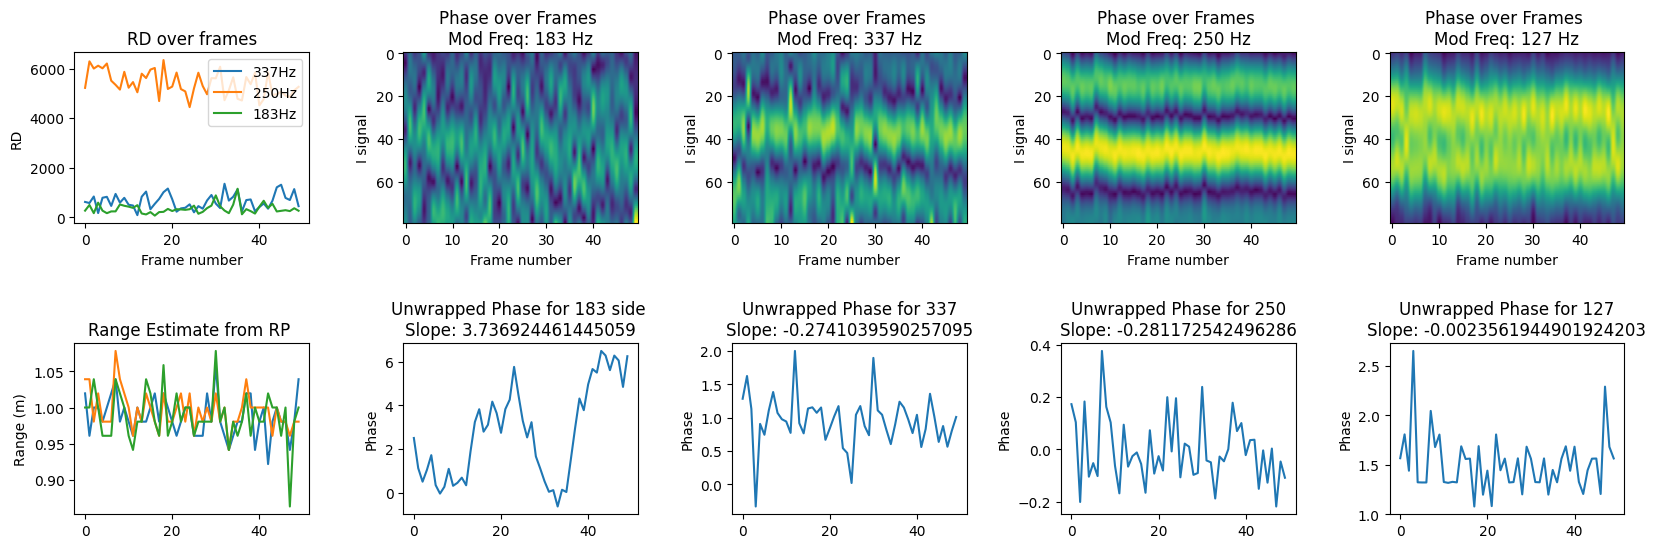

In [52]:
# Initialize plot
# --- QUESTION: what are we doing with the tag / radar for this set of data? 

fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(20, 6))
plt.subplots_adjust(hspace= 0.7, wspace = 0.4)

ax1.set_title("RD over frames")
ax1.set_xlabel("Frame number")
# ax1.set_ylim(75, 175)
ax1.set_ylabel("RD")
dopgrid2 = dopgrid
# dopgrid2[88:92] = 0
# dopgrid2[164:169] = 0
# dopgrid2[0:70] = 0

# ax1.imshow(dopgrid2[90:160], aspect='auto')
ax1.plot(dopgrid2[90])
ax1.plot(dopgrid2[101])
ax1.plot(dopgrid2[106])
ax1.legend(["337Hz", "250Hz", "183Hz"], loc = "upper right")

ax2.set_title("Phase over Frames \nMod Freq: " + str(modfreq1) + " Hz")
ax2.set_xlabel("Frame number")
ax2.set_ylabel("I signal")
ax2.imshow(Igrid[0], aspect='auto')

ax3.set_title("Phase over Frames \nMod Freq: " + str(modfreq2) + " Hz")
ax3.set_xlabel("Frame number")
ax3.set_ylabel("I signal")
ax3.imshow(Igrid[1], aspect='auto')

ax4.set_title("Phase over Frames \nMod Freq: " + str(modfreq3) + " Hz")
ax4.set_xlabel("Frame number")
ax4.set_ylabel("I signal")
ax4.imshow(Igrid[2], aspect='auto')

ax5.set_title("Phase over Frames \nMod Freq: " + str(modfreq4) + " Hz")
ax5.set_xlabel("Frame number")
ax5.set_ylabel("I signal")
ax5.imshow(Igrid[3], aspect='auto')

ax7.set_title("Unwrapped Phase for "+str(modfreq1) +" side " + "\nSlope: " + str(unwrappedDist[n_frames-1]-unwrappedDist[0]))
ax7.set_ylabel("Phase")
# ax6.set_ylim(0, 0.025)
ax7.plot(unwrappedDist)


ax8.set_title("Unwrapped Phase for "+str(modfreq2) + "\nSlope: " + str(unwrappedDist2[n_frames-1]-unwrappedDist2[0]))
ax8.set_ylabel("Phase")
# ax6.set_ylim(0, 0.025)
ax8.plot(unwrappedDist2)

ax9.set_title("Unwrapped Phase for "+str(modfreq3) + "\nSlope: " + str(unwrappedDist3[n_frames-1]-unwrappedDist3[0]))
ax9.set_ylabel("Phase")
# ax6.set_ylim(0, 0.025)
ax9.plot(unwrappedDist3)

ax10.set_title("Unwrapped Phase for "+str(modfreq4) + "\nSlope: " + str(unwrappedDist4[n_frames-1]-unwrappedDist4[0]))
ax10.set_ylabel("Phase")
# ax6.set_ylim(0, 0.025)
ax10.plot(unwrappedDist4)

# print("Displacement 250hz:" + str(unwrappedDist))
# print("Displacement 337hz:" + str(unwrappedDist2))
slope1 = unwrappedDist[n_frames-1]-unwrappedDist[0]
slope2 = unwrappedDist2[n_frames-1]-unwrappedDist2[0]
slope3 = unwrappedDist3[n_frames-1]-unwrappedDist3[0]
slope4 = unwrappedDist4[n_frames-1]-unwrappedDist4[0]

# print("Range average 183Hz: "+ str(np.mean(max_idxs)))
# print("Range average 337Hz: "+ str(np.mean(max_idxs2)))
# print("Range average 240Hz: "+ str(np.mean(max_idxs3)))
# print("Diff in slope: "+str(slope3-slope2))
# ax4.set_title("Difference between two displacements " + "\nDiff: " +str(slope2-slope1))
# ax4.plot(unwrappedDist - unwrappedDist2)

ax6.set_title("Range Estimate from RP ")
ax6.set_ylabel("Range (m)")
ax6.plot(max_idxs)
ax6.plot(max_idxs2)
ax6.plot(max_idxs3)

#phase increase, when closer, decrease when farther
phase_diff1 = (unwrappedDist2)- unwrappedDist3
phase_diff2 = (unwrappedDist2)- (unwrappedDist)

# ax6.set_title("phase difference between\n 337Hz side and the other sides")
# ax6.plot(phase_diff1)
# ax6.plot(phase_diff2)
# ax6.legend(["250Hz", "183Hz"], loc = "upper right")
plt.show()

## AoA Estimation (not working)


IndexError: index 100 is out of bounds for axis 1 with size 89

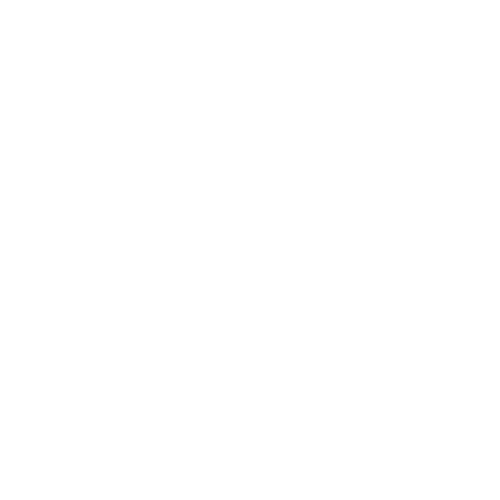

In [26]:
%matplotlib ipympl

data_raw = pickle.load(open('test_static_aoa_45-24Ghz.pickle', 'rb'))
# data_raw = pickle.load(open('test_15cm_across_0-24Ghz.pickle', 'rb'))


antenna_pick = 2
nfft = 2**8
fs = 1e6
c = 2.98e8
range_min = 1
range_max = 5
f_tag = 500

cfg = data_raw['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']

data_signal_raw = data_raw['Data']
# n_frames = data_signal_raw.shape[1]
n_frames = 50

fig = plt.figure(figsize=(5, 5))
def plot_range_angle_fan(theta, rng, P_db, frame,
                         thetalim=(-90, 90), rmax=None):
    """
    theta    : (Nang,) radians
    rng      : (Nr,)   metres
    P_db     : (Nr, Nang) power in dB
    thetalim : displayed angular span in degrees
    rmax     : radial axis limit (defaults to max(rng))
    """
    # 2‑D grids for pcolormesh
    TH, RR = np.meshgrid(theta, rng)

    
    fig.clear()
    ax  = fig.add_subplot(111, projection='polar')
    # put 0° straight down, +θ counter‑clockwise
    ax.set_theta_zero_location('S')
    ax.set_theta_direction(1)

    # show only −90° … +90°
    ax.set_thetamin(thetalim[0])
    ax.set_thetamax(thetalim[1])

    # radial (range) limits
    ax.set_ylim(0, rmax or rng[-1])

    # draw the heat‑map
    pcm = ax.pcolormesh(TH, RR, P_db, shading='auto')

    # tidy up ticks / labels
    ax.set_title("AoA Frame: " + str(frame))
    ax.set_xticks(np.deg2rad([-90, -45, 0, 45, 90]))
    # ax.set_yticklabels([])                    # hide concentric‑circle numbers
    ax.set_ylabel('range', rotation=0, labelpad=30,
                  fontsize=12, va='center')

    cbar = fig.colorbar(pcm, ax=ax, pad=0.08)
    cbar.set_label('Power (dB)')

    plt.tight_layout()
    # plt.show()

    

# ----- after angle_fft -----

def animate_angle(frame):
    AoA = get_angle(
            frame_idx = 2*frame,
            data_raw=data_signal_raw,
            frame_size=frame_size,
            N=N,
            chirp_slope=chirp_slope,
            period=period,
            range_min=range_min,
            range_max=range_max,
            f_tag=f_tag,
            fs=fs,
            nfft=nfft
        )
    v_range = np.arange(nfft) / nfft * fs * c / (2 * chirp_slope)
    r_max_idx = np.argmin(np.abs(v_range - range_max))
    v_range_ext = v_range[: r_max_idx + 1]
    r_offset = np.sum(v_range_ext < 0.1)
    v_u = np.linspace(-1, 1, nfft)
    m_range, m_u = np.meshgrid(v_range, v_u, indexing='ij')
    x = m_range * m_u
    y = m_range * np.cos(np.arcsin(m_u))
    j0 = AoA

    fig.clear()
    ax  = fig.add_subplot(111)
    ax.pcolormesh(x, y, j0, shading='auto', cmap='jet')
    plt.gca().set_aspect('equal')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    # fig.colorbar(label='dB (norm)')
    ax.set_title(f'Angle‑Range Map Frame: '+str(frame))
    # plt.show()
    # # pick Doppler bin you care about, e.g. the strongest target
    # d0 = np.argmax(np.sum(P_ang, axis=2).max(axis=0))
    # print(d0)
    # P_slice = 20*np.log10(P_ang[:, d0, :] + 1e-12)   # add ε to avoid log(0)

    # # range grid that matches your RP/RD processing
    # rng_grid = range_steps                           # (R,)

    # plot_range_angle_fan(theta, rng_grid, P_slice, frame)

animate_angle(50)
# ani = animation.FuncAnimation(fig, animate_angle, frames=n_frames, interval=500, repeat=False)



## Conventional AoA Calculation for specific tag side

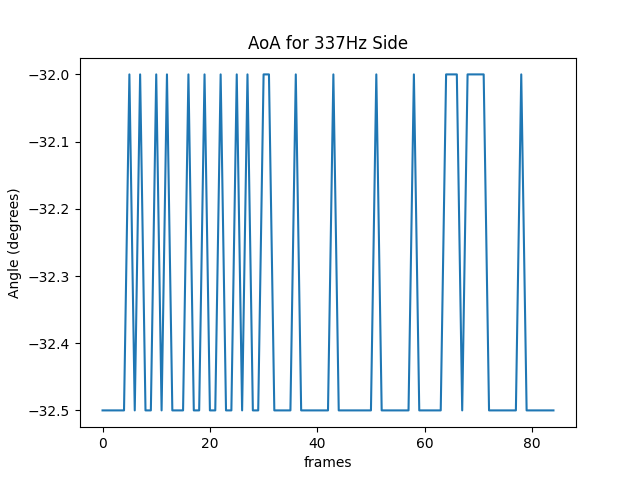

'\nplt.figure()\nplt.plot(theta_scan, 10 * np.log10(P / np.max(P)))\nplt.title("Conventional Beamforming AoA Spectrum")\nplt.xlabel("Angle (degrees)")\nplt.ylabel("Normalized Power (dB)")\nplt.grid(True)\nplt.show()\n'

In [ ]:
# Avery
# data_raw = pickle.load(open('test_2cm_diagonal_0-24GHz.pickle', 'rb'))
data_raw = pickle.load(open('test_static_aoa_45-24Ghz.pickle', 'rb'))
# Radar / array parameters
antenna_pick = 2
nfft = 2**8
fs = 1e6
c = 2.98e8
range_min = 0
range_max = 5
f_tag = 337  # <--- Tag modulation frequency (choose from [183, 337, 250, 127])

cfg = data_raw['Cfg']
frame_size = cfg['FrmMeasSiz']
N = cfg['N']
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']
period = cfg['Perd']
f_c = (cfg['fStrt'] + cfg['fStop']) / 2
lam = c / f_c
d = lam / 2  # Assume half-wavelength spacing
M = data_raw['Data'].shape[2]  # Total antennas

angles = []

frame_idx = 0
for frame_idx in range(0, 85): # <---- make sure this range is valid


    # 1. Use one antenna to find max index
    _, RD_ref, _, max_idxs, range_steps = get_range(
        frame_idx=frame_idx,
        data_raw=data_raw['Data'],
        antenna_pick=antenna_pick,
        frame_size=frame_size,
        N=N,
        chirp_slope=chirp_slope,
        period=period,
        range_min=range_min,
        range_max=range_max,
        f_tag=f_tag,
        fs=fs,
        nfft=nfft
    )

    n0 = int(max_idxs[[183, 337, 250, 127].index(f_tag)])
    k0 = np.argmax(np.abs(RD_ref[n0, :]))  # Doppler bin with strongest return

    # 2. Get RD[n0, k0] from all antennas
    snapshot = np.zeros(M, dtype=complex)
    for m in range(M):
        _, RD_m, _, _, _ = get_range(
            frame_idx=frame_idx,
            data_raw=data_raw['Data'],
            antenna_pick=m,
            frame_size=frame_size,
            N=N,
            chirp_slope=chirp_slope,
            period=period,
            range_min=range_min,
            range_max=range_max,
            f_tag=f_tag,
            fs=fs,
            nfft=nfft
        )
        snapshot[m] = RD_m[n0, k0]

    # 3. Beamforming: Conventional Bartlett
    theta_scan = np.linspace(-90, 90, 361)
    P = np.zeros_like(theta_scan)
    m_idx = np.arange(M)

    for i, th in enumerate(theta_scan):
        th_rad = np.deg2rad(th)
        # steering vector
        a = np.exp(-1j * 2 * np.pi * d * m_idx * np.sin(th_rad) / lam)
        # output power of beamformer
        P[i] = np.abs(a.conj().T @ snapshot) ** 2

    # 4. Estimate AoA
    theta_est = theta_scan[np.argmax(P)]
    # print(f"Estimated AoA = {theta_est:.2f} degrees")
    angles.append(theta_est)


#Plot angle over frames
plt.figure()
plt.plot(angles)
plt.title("AoA for " + str(f_tag) + "Hz Side")
plt.xlabel("frames")
plt.ylabel("Angle (degrees)")
plt.show()

# 5. Plot
"""
plt.figure()
plt.plot(theta_scan, 10 * np.log10(P / np.max(P)))
plt.title("Conventional Beamforming AoA Spectrum")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power (dB)")
plt.grid(True)
plt.show()
"""


# MUSIC Signal Processing

## Angle Doppler (not working)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import pinv, eigh


def music_RAP_angle_Doppler_Real(
    Y: np.ndarray,
    K: int,
    res: float,
    ts: float,
    slope: float,
    carrier_freq: float,
    antenna_dist: float,
    numRX: int,
    smoothing: int,
    T: float,
    startangle: float,
    endangle: float,
    centerDop: float,
):
    """Python translation of MATLAB function music_RAP_angle_Doppler_Real.

    Parameters
    ----------
    Y : np.ndarray
        Measurement matrix of shape (N, L) where N is the number of samples
        (per range bin) and L is the number of RX antennas.
    K : int
        Number of sources/targets to estimate.
    res, ts, slope, carrier_freq, antenna_dist, numRX, smoothing, T, startangle,
    endangle, centerDop :
        Same meaning as in the original MATLAB code.

    Returns
    -------
    indices_New : np.ndarray
        Detected [AoA, Doppler, correlation] for each source (K×3).
    Ahat_New : np.ndarray
        Estimated steering vectors stacked column‑wise (arraySize×K).
    """

    # Ensure array
    Y = np.asarray(Y, dtype=float)
    N, L = Y.shape  # samples × antennas

    # ------------------------------------------------------------------
    # Grid settings (hard‑coded like the original)
    # ------------------------------------------------------------------
    angle_spacing = 2  # deg
    dop_spacing = 2    # Hz

    # --- ranges = [[startangle, endangle],
    #               [   150    ,   400   ]]
    ranges = np.array([[startangle, endangle], [150, 400]])

    AoA = np.arange(ranges[0, 0], ranges[0, 1] + angle_spacing / 2, angle_spacing)
    DopF = np.arange(ranges[1, 0], ranges[1, 1] + dop_spacing / 2, dop_spacing)

    # Build 2‑D search grid (vectorised form)
    grid_shape = (len(DopF), len(AoA))

    # --- np.prod(grid_shape) = len(DopF) * len(AoA)
    # --- np.arange(np.prod(grid_shape)) = [0, 1, 2, ..., np.prod(grid_shape) - 1]
    # --- np.unravel_index(..., grid_shape) : takes flat indices (0, 1, 2 ..., 11) and converts into 2D index with 2D array of shape 
    # ---- grid_shape. Returns: (row_idxs, col_idxs)
    # ---- for example, if grid_shape is (4,3) dop_idx = [0 0 0 1 1 1 2 2 2 3 3 3] and aoa_idx = [0 1 2 0 1 2 0 1 2 0 1 2]
    dop_idx, aoa_idx = np.unravel_index(np.arange(np.prod(grid_shape)), grid_shape)

    # --- pt: doppler values corresponding to the doppler indices 
    pt = ranges[1, 0] + dop_idx * dop_spacing

    # --- zt: angle values corresponding to the angle indices
    zt = ranges[0, 0] + aoa_idx * angle_spacing

    # If zt = [z1, z2, z3, ...] and pt = [p1, p2, p3, ...] then,
    #   ppp = [[z1, z2, z3, ...],
    #          [p1, p2, p3, ...]] 
    # --- ppp: set of all angle, doppler coordinate pairs in the grid. (z1, p1), (z2, p2), ...
    ppp = np.vstack((zt, pt))           # (2, N_grid)

    # ------------------------------------------------------------------
    # Correlation matrix (with optional smoothing)
    # ------------------------------------------------------------------
    
    # --- Received correlation matrix : R = Y.Y^H
    R = Y @ Y.conj().T  # (N, N)

    if smoothing == 1:  
        # forward–backward spatial smoothing to improve covariance estimates
        # --- np.eye(R.shape[0]) = Identity matrix of NxN size 
        # --- np.fliplr() : flips I_nxn left to right 
        # --- example: if N=4 (I_4x4) then 
        # ---- np.fliplr(I) = [[0, 0, 0, 1],
        #                      [0, 0, 1, 0],
        #                      [0, 1, 0, 0],
        #                      [1, 0, 0, 0]]
        J = np.fliplr(np.eye(R.shape[0]))
        R = R + J @ R.conj() @ J

    elif smoothing == 2:
        # TODO: spatial smoothing – not implemented (same as MATLAB stub)
        pass

    # ------------------------------------------------------------------
    # Eigen‑decomposition & signal sub‑space (largest K eigenvectors)
    # ------------------------------------------------------------------
    eigvals, eigvecs = eigh(R)
    order = eigvals.argsort()[::-1]    # gets the indices in sorted order 
    
    # extracting the eigenvectors corresponding to the K-smallest eigenvalues 
    # --- order[:K] : first K indices (K = number of targets)
    Q = eigvecs[:, order[:K]]  # (N, K)

    # ------------------------------------------------------------------
    # Build global steering matrix for the 2‑D grid
    # ------------------------------------------------------------------
    c = 3e8                             # speed of light
    array_size = N                      # identical to MATLAB (no spatial smoothing path)
    n = np.arange(array_size // numRX)  # slow‑time index per antenna ??

    # Z : 2D steering matrix 
    # --- ppp.shape[1] = N_grid 
    Z = np.zeros((array_size, ppp.shape[1]), dtype=complex)

    seg = array_size // numRX           # segment size
    # 0‑th antenna
    # --- n = [0, 1, 2, ..., array_size // numRX]
    # --- ppp[1] = [p1, p2, ..., p_Ngrid] : doppler values 
    # --- np.outer(n, ppp[1]): outer product between n and ppp[1]
    # --- gives us [[0,     0,      0, ... ],
    #               [p1,    p2,     p3, ...],
    #               [2p1,   2p2,    2p3,...],
    #               [ .      .       .     ],
    #               [ .      .       .     ],
    #               [ .      .       .     ]]  
    Z[0:seg, :] = np.cos(2 * np.pi * np.outer(n, ppp[1]) * T)

    # --- 2 * np.pi * antenna_dist * np.sin(np.deg2rad(ppp[0])) * (carrier_freq / c) : Phase difference due to antenna separation
    # --- 2 * np.pi * np.outer(n, ppp[1]) * T : Phase diff. due to doppler (TODO: unpack this!)
    # 1‑st antenna
    Z[seg:2 * seg, :] = np.cos(
        2 * np.pi * np.outer(n, ppp[1]) * T
        + 2 * np.pi * antenna_dist * np.sin(np.deg2rad(ppp[0])) * (carrier_freq / c)
    )

    # 2‑nd antenna
    Z[2 * seg : 3 * seg, :] = np.cos(
        2 * np.pi * np.outer(n, ppp[1]) * T
        + 2 * np.pi * 2 * antenna_dist * np.sin(np.deg2rad(ppp[0])) * (carrier_freq / c)
    )
    
    # 3‑rd antenna
    Z[3 * seg :, :] = np.cos(
        2 * np.pi * np.outer(n, ppp[1]) * T
        + 2 * np.pi * 3 * antenna_dist * np.sin(np.deg2rad(ppp[0])) * (carrier_freq / c)
    )
    # Z = np.zeros((array_size,), dtype=complex)
    # ------------------------------------------------------------------
    # Iterative RAP‑MUSIC search
    # ------------------------------------------------------------------
    indices_New = []
    Ahat_list = []
    for k in range(K):
        indices, Ahat = _rap_music_single(
            Z,                  # NN = Z (N x N_grid 2D steering matrix)
            Q,                  # SS = Q (Q: eigenvectors corresponding to the K-smallest eigenvalues)
            indices_New,
            n,
            k,                  # iteration index
            AoA,
            DopF,
            res,
            slope,
            ts,
            c,
            carrier_freq,
            array_size,
            antenna_dist,
            N // numRX,
            T,
            L,
        )
        indices_New.append(indices)
        Ahat_list.append(Ahat)

    indices_New = np.vstack(indices_New)  # (K, 3)
    Ahat_New = np.column_stack(Ahat_list)  # (array_size, K)
    return indices_New, Ahat_New


# ----------------------------------------------------------------------
# Helper functions
# ----------------------------------------------------------------------

def _rap_music_single(
    SS: np.ndarray,             # NN = Z (N x N_grid 2D steering matrix)
    NN: np.ndarray,             # SS = Q (Q: eigenvectors corresponding to the K-smallest eigenvalues)
    indices_prev: list,
    n: np.ndarray,
    ind: int,                   # iteration index 
    AoA: np.ndarray,
    DopF: np.ndarray,
    res: float,
    slope: float,
    ts: float,
    c: float,
    carrier_freq: float,
    array_size: int,
    antenna_dist: float,
    N_seg: int,
    T: float,
    L: int,
):
    """One iteration of RAP‑MUSIC (Python port)."""

    # ------------------------------------------------------------------
    # Projection to sub‑space orthogonal to previously found steering vecs
    # ------------------------------------------------------------------
    if ind > 0:
        # --- calculates the steering vectors for previous and stacks them in a column vector 
        Ahat_prev = np.column_stack(
            [
                _calculate_steering_vec_2d_real(
                    idx[0],
                    idx[1],
                    slope,
                    n,
                    ts,
                    c,
                    carrier_freq,
                    array_size,
                    antenna_dist,
                    T,
                    L,
                )
                for idx in indices_prev
            ]
        )
        Perp = np.eye(Ahat_prev.shape[0]) - Ahat_prev @ pinv(Ahat_prev.T @ Ahat_prev) @ Ahat_prev.T
    else:
        Perp = np.eye(NN.shape[0])

    NN_proj = Perp @ NN   
    Ps = NN_proj @ NN_proj.T

    SS_proj = Perp @ SS
    PsA = Ps @ SS_proj

    num = np.sum(SS_proj.T * PsA.T, axis=1)
    den = np.sum(SS_proj.T * SS_proj.T, axis=1)
    spectrum = np.abs(num / den)

    # Locate peak
    peak_idx = np.argmax(spectrum)
    dop_idx, aoa_idx = np.unravel_index(peak_idx, (len(DopF), len(AoA)))
    indices = np.array([AoA[aoa_idx], DopF[dop_idx], spectrum[peak_idx]])

    # Steering vector for this peak
    Ahat = _calculate_steering_vec_2d_real(
        indices[0],
        indices[1],
        slope,
        n,
        ts,
        c,
        carrier_freq,
        array_size,
        antenna_dist,
        T,
        L,
    )

    # Optional: visualise MUSIC spectrum (comment out if not needed)
    Pmusic = spectrum.reshape(len(DopF), -1).T
    # Pmusic[:,200:300] = 0
    plt.figure()
    plt.imshow(Pmusic, extent=[DopF[0], DopF[-1], AoA[-1], AoA[0]], aspect="auto")
    plt.xlabel("Doppler (Hz)")
    plt.ylabel("AoA (deg)")
    plt.title(f"RAP‑MUSIC iteration {ind+1}")
    plt.colorbar(label="Pseudo‑spectrum")

    return indices, Ahat


def _calculate_steering_vec_2d_real(
    AoA: float,
    DopF: float,
    slope: float,
    n: np.ndarray,
    ts: float,
    c: float,
    carrier_freq: float,
    array_size: int,
    antenna_dist: float,
    T: float,
    L: int,
) -> np.ndarray:
    """Generate steering vector (real‑valued cosine) for AoA & Doppler."""

    seg = array_size // 4  # assumes 4‑RX like original code
    Z = np.zeros((array_size,), dtype=complex)

    for rx in range(4):
        phase_doppler = 2 * np.pi * DopF * n * T                                                  # doppler component of phase  
        phase_aoa = 2 * np.pi * rx * antenna_dist * np.sin(np.deg2rad(AoA)) * (carrier_freq / c)  # aoa component of phase
        Z[rx * seg:(rx + 1) * seg] = np.exp(1j * (phase_doppler + phase_aoa))
    
    # --- Z.reshape(-1, 1) : flattens out Z into a column vector (-1 is a placeholder to auto-calc #rows)
    return Z.reshape(-1, 1)


/tmp/ipykernel_330226/3020912672.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  Y = np.asarray(Y, dtype=float)


indicesNew = [[-2.00000000e+01  3.58000000e+02  2.38630864e-02]
 [-8.00000000e+00  2.72000000e+02  5.33287265e+01]]
Ahat_new = [[ 1.        +0.j          1.        +0.j        ]
 [ 0.52997847+0.8480111j   0.71856341+0.69546145j]
 [-0.43824565+0.89885525j  0.03266675+0.9994663j ]
 [-0.99449998+0.10473675j -0.67161715+0.74089838j]
 [-0.61588151-0.7878388j  -0.99786577+0.06529863j]
 [ 0.34169211-0.93981195j -0.76244251-0.64705596j]
 [ 0.97806043-0.2083214j  -0.09786082-0.99520011j]
 [ 0.69500982+0.71900024j  0.62180411-0.78317281j]
 [-0.24137994+0.97043069j  0.99147218-0.13031854j]
 [-0.95086217+0.3096145j   0.80306715+0.59588854j]
 [-0.76649301-0.64225265j  0.16263717+0.98668594j]
 [ 0.13841259-0.99037465j -0.56933692+0.8221043j ]
 [ 0.91320439-0.40750183j -0.98084652+0.19478219j]
 [ 0.82954474+0.55844026j -0.84026393-0.54217759j]
 [-0.03392269+0.99942446j -0.2267193 -0.97396014j]
 [-0.86550133+0.50090663j  0.51443953-0.85752666j]
 [-0.88347145-0.46848501j  0.96603416-0.25841442j]
 [-0.0

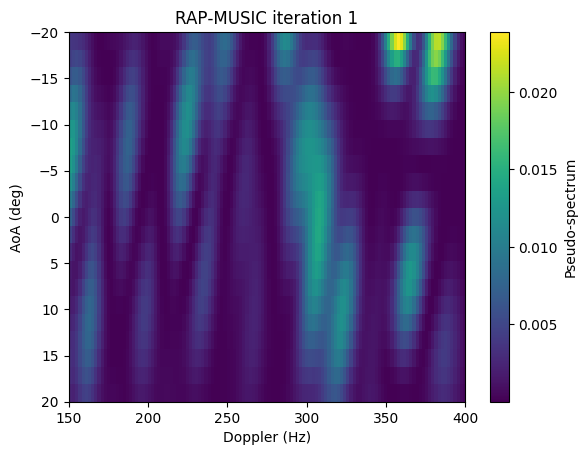

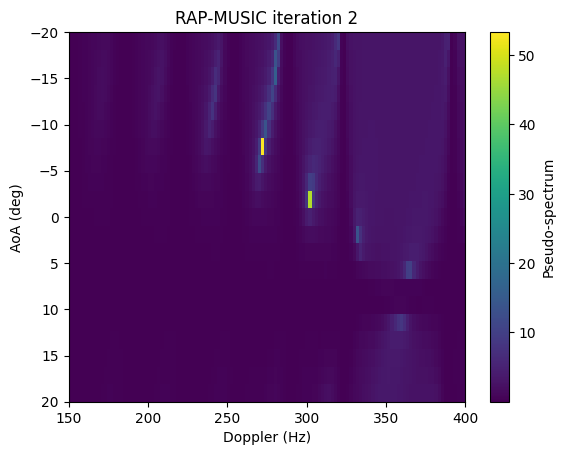

In [56]:
data_raw = pickle.load(open('straight_100cm_H-24GHz.pickle', 'rb'))

antenna_pick = 2
nfft = 2**8
fs = 1e6
c = 3e8
range_min = 0
range_max = 2
f_tag = 240
num_rx = 4
f_carrier= 24.125e9

cfg = data_raw['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
calDat = data_raw['CalDat']

data_signal_raw = data_raw['Data']
# n_frames = data_signal_raw.shape[1]
n_frames = 50

dopwidth = 80 #width of doppler
Igrid = np.zeros((4,dopwidth, n_frames))
Qgrid = np.zeros((4,dopwidth, n_frames))
Pgrid = np.zeros((4,dopwidth, n_frames))
dopgrid = np.zeros((nfft, n_frames))

max_idxs = np.zeros(n_frames)
max_idxs2 = np.zeros(n_frames)
max_idxs3 = np.zeros(n_frames)
max_idxs4 = np.zeros(n_frames)

# for frame in range(0,n_frames):
    # Call get_range and return computed RP, RD, csweep
frame = 8

RP_cube = np.zeros((256, 256, 4), dtype='complex128')

# loop over antennas to get the RP_cube 
for antenna in [0,1,2,3]:
    RP, RD, csweep, max_idx, range_steps = get_range(
        frame_idx = frame+2,
        data_raw=data_signal_raw,
        antenna_pick=antenna,
        frame_size=frame_size,
        N=N,
        chirp_slope=chirp_slope,
        period=period,
        range_min=range_min,
        range_max=range_max,
        f_tag=f_tag,
        fs=fs,
        nfft=nfft
    )
    RP_cube[:, :, antenna] = RP

# let's select range bin 20
indicesNew, Ahat_new = music_RAP_angle_Doppler_Real(Y = RP_cube[20, :, :], 
                                                    K = 2, 
                                                    res = 0,                # res is unused in rap_music_single 
                                                    ts=1/fs,
                                                    slope = chirp_slope,
                                                    carrier_freq=f_carrier,
                                                    antenna_dist= c/(f_carrier*2),
                                                    numRX = num_rx,
                                                    smoothing = 1,
                                                    T = period,
                                                    startangle = -20, 
                                                    endangle = 20,
                                                    centerDop = 0)          # what is centerDop? ---unused--- 

print(f"indicesNew = {indicesNew}")
print(f"Ahat_new = {Ahat_new}")

## Range Doppler (not working)

In [108]:
import numpy as np
from numpy.linalg import eigh, pinv

# ---------------------------------------------------------------------
# Main entry point
# ---------------------------------------------------------------------
def music_RAP_range_doppler_real(
        Y,                     # (N, L) complex beat‑signal matrix
        K,
        res,
        ts,
        slope,
        carrier_freq,
        antenna_dist,
        num_chirp,
        smoothing,
        T,
        start_range,
        end_range):
    """
    Port of MATLAB function `music_RAP_range_Doppler_Real`.

    Returns
    -------
    indices_new : (K, 3) ndarray
        Each row = [range (m), Doppler (Hz), MUSIC‑spectrum peak].
    Ahat_new    : (N, K) ndarray
        Steering vectors corresponding to each peak.
    """

    c = 3.0e8                                  # light speed (m s‑1)
    L  = Y.shape[1]                            # Rx channels
    N  = Y.shape[0]                            # samples per frame

    # -----------------------------------------------------------------
    # Build search grid
    # -----------------------------------------------------------------
    tau_spacing = res
    dop_spacing = 2.0

    tof   = np.arange(start_range, end_range + 1e-12, tau_spacing)
    dop_f = np.arange(300.0, 400.0 + 1e-12, dop_spacing)              # Hz
    n_toF, n_dop = tof.size, dop_f.size
    grid_shape   = (n_toF, n_dop)                                    # (row, col)

    # -----------------------------------------------------------------
    # Form/condition the auto‑correlation matrix R
    # -----------------------------------------------------------------
    R = Y @ Y.conj().T                                               # (N, N)

    if smoothing == 1:                                               # forward‑backward
        J = np.fliplr(np.eye(R.shape[0]))
        R = R + J @ R.conj() @ J
    # (smoothing==2 “spatial” is TODO in the original MATLAB, so we leave it.)

    # -----------------------------------------------------------------
    # Noise subspace: keep K largest eigenvectors
    # -----------------------------------------------------------------
    eigvals, eigvecs = eigh(R)
    order = np.argsort(eigvals)[::-1]                                # descending
    Q = eigvecs[:, order[:K]]                                        # (N, K)

    # -----------------------------------------------------------------
    # Pre‑compute the steering dictionary Z
    #   • rows  = grid points  (|grid| = n_toF × n_dop)
    #   • cols  = slow‑time samples (N)
    # -----------------------------------------------------------------
    seg_len = N // num_chirp                                         # samples per chirp
    n = np.arange(seg_len)                                           # 0 … seg_len‑1
    two_pi_slope_ts_over_c = 2.0 * np.pi * slope * ts / c

    # allocate once for efficiency
    Z = np.empty((N, n_toF * n_dop), dtype=float)    # (N, |grid|)

    for ch in range(num_chirp):
        row_idx = slice(ch * seg_len, (ch + 1) * seg_len)
        # range‑dependent phase term, shape (seg_len, n_toF)
        range_phase = two_pi_slope_ts_over_c * np.outer(n, 2.0 * tof)
        # Doppler phase term, shape (n_dop,)
        doppler_phase = 2.0 * np.pi * dop_f * ch * T
        # Broadcast + reshape: (seg_len, n_toF, n_dop)
        cos_arg = (range_phase[:, :, None] + doppler_phase)
        Z_block = np.cos(cos_arg).reshape(seg_len, -1, order='F')    # MATLAB column‑major
        Z[row_idx, :] = Z_block                                      # transpose later

    Z = Z.T                                                          # (|grid|, N)

    # -----------------------------------------------------------------
    # RAP‑MUSIC search
    # -----------------------------------------------------------------
    indices_new = np.zeros((K, 3))
    Ahat_new    = np.zeros((N, K), dtype=float)

    for k in range(K):
        indices, Ahat = _rap_music(
            Z, Q[:, :k+1], indices_new[:k], n, k,
            tof, dop_f, res, end_range, slope, ts, c, carrier_freq,
            N, antenna_dist, seg_len, T, L, num_chirp)

        indices_new[k, :] = indices
        Ahat_new[:,  k]   = Ahat

    return indices_new, Ahat_new


# ---------------------------------------------------------------------
# Helper: RAP‑MUSIC 2‑D peak search
# ---------------------------------------------------------------------
def _rap_music(Z, Q, indices_prev, n, ind,
               tof, dop_f, res, end_range,
               slope, ts, c, carrier_freq,
               N, antenna_dist, seg_len, T, L, num_chirp):

    # --------------------------------------------------------------
    # Build projection matrix that nulls previously‑found sources
    # --------------------------------------------------------------
    if ind > 0:
        A_prev = np.stack([_steering_vec_2d(
                               indices_prev[i, 0],                 # range
                               indices_prev[i, 1],                 # Doppler
                               slope, n, ts, c, carrier_freq,
                               N, antenna_dist, seg_len, T, L, num_chirp)
                           for i in range(ind)], axis=1)
        P_perp = np.eye(N) - A_prev @ pinv(A_prev.T @ A_prev) @ A_prev.T
    else:
        P_perp = np.eye(N)

    Qp   = P_perp @ Q                   # project noise subspace
    Ps   = Qp @ Qp.T
    SSp  = P_perp @ Z.T                 # (N, |grid|)
    num  = np.sum(SSp.conj() * (Ps @ SSp), axis=0)
    den  = np.sum(SSp.conj() * SSp,      axis=0)
    P_mu = np.abs(num / den)            # MUSIC spectrum, shape (|grid|,)

    best_idx = np.argmax(P_mu)
    r_idx, d_idx = np.unravel_index(best_idx, (tof.size, dop_f.size), order='F')
    peak = P_mu[best_idx]

    indices = np.array([tof[r_idx], dop_f[d_idx], peak])

    Ahat = _steering_vec_2d(
        indices[0], indices[1],
        slope, n, ts, c, carrier_freq,
        N, antenna_dist, seg_len, T, L, num_chirp)
    P_mu = P_mu.reshape(len(dop_f), len(tof)).T
    # Pmusic[:,200:300] = 0
    plt.figure()
    plt.imshow(P_mu, extent=[dop_f[0], dop_f[-1], tof[-1], tof[0]], aspect="auto")
    plt.xlabel("Doppler (Hz)")
    plt.ylabel("Tof (M)")
    plt.title(f"RAP‑MUSIC iteration {ind+1}")
    plt.colorbar(label="Pseudo‑spectrum")
    return indices, Ahat


# ---------------------------------------------------------------------
# Helper: real 2‑D steering vector for a single (range, Doppler) pair
# ---------------------------------------------------------------------
def _steering_vec_2d(d, dop_f,
                     slope, n, ts, c, carrier_freq,
                     N, antenna_dist, seg_len, T, L, num_chirp):
    """
    Real‑valued steering vector, exactly the same arithmetic
    as `calculateSteeringVec2D_real` in MATLAB.
    """
    two_pi_slope_ts_over_c = 2.0 * np.pi * slope * ts / c
    Z = np.empty(N, dtype=float)

    for ch in range(num_chirp):
        seg_slice = slice(ch * seg_len, (ch + 1) * seg_len)
        Z[seg_slice] = np.cos(two_pi_slope_ts_over_c * n * 2.0 * d
                              + 2.0 * np.pi * dop_f * ch * T)

    return Z



## Joint AoA-ToF 2D Algorithm 

In [ ]:
from __future__ import annotations
import numpy as np
from numpy.linalg import pinv
from scipy.linalg import eigh          # Hermitian eigen‑solver
from typing import Tuple, Optional

c0 = 3.0e8  # speed of light


# ──────────────────────────────────────────────────────────────────────────────
#  Main entry point
# ──────────────────────────────────────────────────────────────────────────────
def music_RAP_2D_real(
        Y: np.ndarray,
        K: int,
        res: float,
        ts: float,
        slope: float,
        carrier_freq: float,
        antenna_dist: float,
        num_rx: int,
        smoothing: int,
        start_range: float,
        end_range: float,
        start_ang: float,
        end_ang: float,
        angle_spacing: float = 0.1
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Estimate K paths (AoA + ToF) with the RAP‑MUSIC algorithm.

    Parameters
    ----------
    Y : (N, L) ndarray
        Snapshot matrix   (range‑FFT × antennas)   **after** any windowing etc.
    K : int
        How many peaks (signals) to extract.
    res : float
        Grid spacing for ToF (same units as *start_range* / *end_range*).
    ts : float
        ADC sample period (s).
    slope : float
        Chirp slope (Hz/s).
    carrier_freq : float
        RF centre frequency (Hz).
    antenna_dist : float
        Antenna element spacing (m).
    num_rx : int
        Number of RX antennas.
    smoothing : {0,1,2}
        0 = none, 1 = forward/backward, 2 = spatial 2‑D smoothing.
    start_range, end_range : float
        ToF search window (m).
    start_ang, end_ang : float
        AoA search window (deg).
    angle_spacing : float, optional
        Angular grid step (deg).

    Returns
    -------
    indices_new : (K, 3) ndarray
        [AoA(deg), ToF(m), MUSIC‑peak] for each detected path.
    ahat_new :   (N, K) ndarray
        Steering vectors of the detected paths (optional use).
    """
    # ------------------------------------------------------------------ grids
    L = Y.shape[1]          # snapshots
    N = Y.shape[0]          # fast‑time (range bins × antennas)

    
    tau_spacing = res
    aoa = np.arange(start_ang, end_ang + 1e-9, angle_spacing)     # deg
    tof = np.arange(start_range, end_range + 1e-9, tau_spacing)   # m

    n_toF, n_aoa = len(tof), len(aoa)

    # meshgrid, then vectorise like MATLAB’s IND2SUB usage
    zt, qt = np.meshgrid(tof, aoa, indexing="xy")   # qt‑>angle, zt‑>range
    qt = qt.ravel()
    zt = zt.ravel()
    ppp = np.vstack((qt, zt))                       # (2, grid_points)

    # ---------------------------------------------------------------- smooth
    if smoothing == 2:
        # R = spatial_smooth_2d(Y, round((N / num_rx) / 2), num_rx)  # doesn't exist
        array_size = R.shape[0]
    else:
        array_size = N
        R = (Y @ Y.conj().T) / L
    # forward / backward smoothing
    if smoothing == 1:
        J = np.fliplr(np.eye(array_size))
        R = R + J @ R.conj() @ J

    # ---------------------------------------------------------------- eig‑decomp
    # take the 6 largest eigenvectors (as in MATLAB code)
    w, V = eigh(R)                     # ascending order
    Q = V[:, -6:]                      # largest six
    # keep the first K for the signal sub‑space
    # ---------------------------------------------------------------- steering grid
    n = np.arange(array_size // num_rx)        # slow‑time index per antenna
    Z = build_steering_grid(ppp, n, slope, ts, carrier_freq, antenna_dist, array_size)
    # ---------------------------------------------------------------- RAP‑MUSIC search
    indices_new = np.empty((K, 3))
    ahat_new = np.empty((array_size, K), dtype=complex)
    for k in range(0,K):
        indices, ahat, P_music = _rap_music_iteration(
            Z, Q, indices_new[:k, :], k,
            tof, aoa, res, slope, ts, carrier_freq,
            antenna_dist, n, array_size
        )
        if indices is None:
            indices_new[k, :] = np.nan
        else:
            indices_new[k, :] = indices
            ahat_new[:, k] = ahat.ravel()
    plot_music_spectrum(np.reshape(P_music,(len(aoa), len(tof)),), aoa, tof)
    return indices_new, ahat_new

# ──────────────────────────────────────────────────────────────────────────────
#  Helpers
# ──────────────────────────────────────────────────────────────────────────────
def build_steering_grid(ppp: np.ndarray,
                        n: np.ndarray,
                        slope: float,
                        ts: float,
                        fc: float,
                        d_ant: float,
                        array_size: int) -> np.ndarray:
    """
    Create the big steering‑vector dictionary Z used in the grid search.
    """
    # quarter lengths
    qlen = array_size // 4
    two_pi = 2.0 * np.pi

    # pre‑compute pieces that repeat.
    phase_range = -two_pi * slope * np.outer(n, 2 * ppp[1, :]) * ts / c0
    sin_term = np.sin(np.deg2rad(ppp[0, :]))       # ppp[0,:] is AoA in deg
    phase_ang_1 = -two_pi * d_ant * sin_term * (fc / c0)
    phase_ang_2 = -two_pi * 2 * d_ant * sin_term * (fc / c0)
    phase_ang_3 = -two_pi * 3 * d_ant * sin_term * (fc / c0)
    
    Z = np.empty((array_size, ppp.shape[1]), dtype=complex)

    # this was changed from real cosin approach to complex exponential
    Z[0:qlen, :]         = np.exp(1j * phase_range)
    Z[qlen:2*qlen, :]    = np.exp(1j * (phase_range + phase_ang_1))
    Z[2*qlen:3*qlen, :]  = np.exp(1j * (phase_range + phase_ang_2))
    Z[3*qlen:4*qlen, :]  = np.exp(1j * (phase_range + phase_ang_3))

    return Z


def _rap_music_iteration(Z: np.ndarray,
                         Q: np.ndarray,
                         prev_indices: np.ndarray,
                         ind: int,
                         tof: np.ndarray,
                         aoa: np.ndarray,
                         res: float,
                         slope: float,
                         ts: float,
                         fc: float,
                         d_ant: float,
                         n: np.ndarray,
                         array_size: int) -> Tuple[Optional[np.ndarray], Optional[np.ndarray]]:
    """
    One step of RAP‑MUSIC: project out previously found steering vectors
    and locate the next peak.
    """
    # ---------------------------------------------------------------- project previous paths
    if ind > 0:
        Ahat = np.column_stack([
            steering_vec_2d_real(prev_indices[i, 1],   # d (ToF)
                                 prev_indices[i, 0],   # AoA
                                 slope, n, ts, fc, d_ant, array_size)
            for i in range(ind)
        ])
        perp = np.eye(Ahat.shape[0]) - Ahat @ pinv(Ahat.conj().T @ Ahat) @ Ahat.conj().T
    else:
        Ahat = np.empty((array_size, 0))
        perp = np.eye(Q.shape[0])

    NN = perp @ Q
    Ps = NN @ NN.conj().T

    SSp = perp @ Z
    PsA = Ps @ SSp

    num = np.sum(SSp.conj().T * PsA.T, axis=1)
    den = np.sum(SSp.conj().T * SSp.T,  axis=1)
    P_music = np.abs(num / den)

    peak_idx = np.argmax(P_music)
    aoa_idx, tof_idx = np.unravel_index(peak_idx, (len(aoa), len(tof)))
    indices = np.array([aoa[aoa_idx], tof[tof_idx], P_music[peak_idx]])
    ahat    = steering_vec_2d_real(indices[1], indices[0],
                                   slope, n, ts, fc, d_ant, array_size)
    
    # plot_music_spectrum(P_music.reshape(len(aoa), len(tof)), aoa, tof)

    return indices, ahat, P_music


def steering_vec_2d_real(d: float,        # ToF (m)
                         aoa_deg: float,  # AoA (deg)
                         slope: float,
                         n: np.ndarray,
                         ts: float,
                         fc: float,
                         d_ant: float,
                         array_size: int) -> np.ndarray:
    """
    Real (cosine) steering vector for one path.
    """
    qlen = array_size // 4
    two_pi = 2.0 * np.pi
    phase_r = -two_pi * slope * np.outer(n, 2*d) * ts / c0
    sin_a   = np.sin(np.deg2rad(aoa_deg))
    phase_a1 = -two_pi * d_ant *   sin_a * (fc / c0)
    phase_a2 = -two_pi * 2*d_ant * sin_a * (fc / c0)
    phase_a3 = -two_pi * 3*d_ant * sin_a * (fc / c0)

    z = np.empty((array_size, 1), dtype=complex)
    z[0:qlen, 0]         = np.exp(1j * phase_r).ravel()
    z[qlen:2*qlen, 0]    = np.exp(1j * (phase_r + phase_a1)).ravel()
    z[2*qlen:3*qlen, 0]  = np.exp(1j * (phase_r + phase_a2)).ravel()
    z[3*qlen:4*qlen, 0]  = np.exp(1j * (phase_r + phase_a3)).ravel()

    return z


# # ──────────────────────────────────────────────────────────────────────────────
# #  (Optional) spectrum plotting
# # ──────────────────────────────────────────────────────────────────────────────
def plot_music_spectrum(P_music: np.ndarray,
                        aoa: np.ndarray,
                        tof: np.ndarray) -> None:
    """
    Convenience helper to visualise the MUSIC spectrum.

    Parameters
    ----------
    P_music : (len(aoa), len(tof)) ndarray
        2‑D spectrum matrix (already reshaped).
    aoa, tof : 1‑D arrays
        Angle and ToF axes used for *P_music*.
    """
    # import matplotlib.pyplot as plt

    plt.figure()
    plt.imshow(P_music.T,
                   extent=[aoa[0], aoa[-1],tof[-1], tof[0]],
                   aspect='auto')
    plt.xlabel("AoA (deg)")
    plt.ylabel("Range / ToF (m)")
    plt.title("RAP‑MUSIC 2‑D Spectrum")
    # im = ax.imshow(P_music.T,
    #                extent=[aoa[0], aoa[-1],tof[-1], tof[0]],
    #                aspect='auto')
    # ax.set_xlabel("AoA (deg)")
    # ax.set_ylabel("Range / ToF (m)")
    # ax.set_title("RAP‑MUSIC 2‑D Spectrum")
    # # plt.colorbar(im, ax=ax, label="Pseudo‑power")
    # plt.tight_layout()
    plt.show()



## Root Music (not working)

In [9]:
import numpy as np
from numpy.linalg import eigh
from numpy.polynomial import Polynomial

def root_music(Y, K, d_over_lambda):
    """
    Estimate AoAs using the ROOT-MUSIC algorithm.

    Parameters:
    -----------
    Y : ndarray (N_sensors x snapshots)
        The input data matrix
    K : int
        Number of sources
    d_over_lambda : float
        Antenna spacing in units of the wavelength (d / lambda)

    Returns:
    --------
    angles_deg : ndarray
        Estimated AoAs in degrees
    """

    N = Y.shape[0]
    
    # Estimate covariance matrix
    R = Y @ Y.conj().T / Y.shape[1]
    
    # Eigen decomposition
    eigvals, eigvecs = eigh(R)
    E_n = eigvecs[:, :-K]  # Noise subspace (assumes eigenvalues are ascending)

    # Polynomial coefficients from noise subspace projection
    P = np.zeros(2*N - 1, dtype=complex)
    for m in range(N):
        for n in range(N):
            P[m - n + N - 1] += np.conj(E_n[m, :]) @ E_n[n, :]

    # Construct polynomial from symmetric Toeplitz matrix
    coeffs = P[N-1:]  # Keep only one side (roots inside unit circle)
    roots = np.roots(coeffs[::-1])  # Reverse coefficients for correct poly

    # Select roots closest to unit circle
    roots_on_circle = roots[np.argsort(np.abs(np.abs(roots) - 1))[:K]]

    # Estimate angles from roots
    angles_rad = np.angle(roots_on_circle)
    angles_deg = np.arcsin(angles_rad / (2 * np.pi * d_over_lambda)) * 180 / np.pi
    angles_deg = np.real(angles_deg)

    return np.sort(angles_deg)


## Data Processing

In [ ]:
# %matplotlib ipympl
data_raw = pickle.load(open('test_pseudo_aoa_30_tof_1m-24GHz.pickle', 'rb'))

antenna_pick = 2
num_rx = 4
nfft = 2**8
fs = 1e6
c = 3e8
range_min = 0.5
range_max = 3
f_tag = 337
f_carrier= 24.125e9
cfg = data_raw['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
calDat = data_raw['CalDat']
data_signal_raw = data_raw['Data']
# n_frames = data_signal_raw.shape[1]
n_frames = 85
slice_size = 64 # number of chirps per slice per frame (put 256 for entire frame)

freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

binsleft = [113, 106, 101, 90]
binsright = [144, 150, 155,166]
binleft = int(binsleft[[127, 183, 250,337 ].index(f_tag)])
binright = int(binsleft[[127, 183, 250,337 ].index(f_tag)])

# fig = plt.figure(figsize=(5, 5))
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# plt.tight_layout
def animate_music(frame, slice_size):
    RP, RD, csweep, max_idxs, range_steps = get_range(
        frame_idx = frame,
        data_raw=data_signal_raw,
        antenna_pick=antenna_pick,
        frame_size=frame_size,
        N=N,
        chirp_slope=chirp_slope,
        period=period,
        range_min=range_min,
        range_max=range_max,
        f_tag=f_tag,
        fs=fs,
        nfft=nfft
    )
    range_est = range_steps[int(max_idxs[0])]

    data = data_signal_raw[:,frame, :]      # shape → (N, m, n_rx)
    data  = np.reshape(data, (N, frame_size, num_rx), order='F')
    data = data - data[:, 0:1,:]

    for i in range(data.shape[1]):
        data[:,i,:] = data[:,i,:] - data[:,i,:].mean()
    
    data_filtered = np.empty((N, frame_size, num_rx), dtype=complex)
    all_indices = []
    for slice in range(int(frame_size/slice_size)):
        
        for i in range(num_rx):
            # hanning window used for getting RP
            Win2D = hanning(N, slice_size)

            # taking FFT for one slice in frame
            RP = np.fft.fft(data[:,slice*slice_size:(slice+1)*slice_size,i]*Win2D, n=N, axis=0)
            WinVel2D = hanning(int(slice_size), N)
            WinVel2D = WinVel2D.transpose()

            # getting RD
            RPExt = RP - np.mean(RP, axis=1)[:,np.newaxis]
            RD = np.fft.fft(np.multiply(RPExt, WinVel2D), n=nfft, axis=1)
            RD = np.fft.fftshift(RD, axes=(1,))
            RD_filtered = np.zeros_like(RD)
            RD_filtered[:,binleft] = RD[:,binleft]
            RD_filtered[:,binright] = RD[:,binright]
            RD_unshifted = np.fft.ifftshift(RD_filtered, axes=(1,))

            # Step 2: Apply inverse FFT along Doppler axis (axis=1)
            RP_filtered = np.fft.ifft(RD_unshifted, axis=1)
            data_filtered[:,:,i] = np.fft.ifft(RP_filtered, axis=0)

        win = np.hanning(N)          # shape: (N‑1,)
        win = win[:, None, None]         # add two singleton axes
        Win2D = np.tile(win, (1, frame_size, num_rx))
        prod = data_filtered * Win2D 
        prod_perm = np.transpose(prod, (0,2,1))

        # final array to send to MUSIC. 
        # each column contains filtered chirp sample data from the 4 RX ant
        # total of 256 columns (from FFT)
        prod_reshaped = np.reshape(prod_perm, (N*num_rx, frame_size), order='F')

        # ax.clear()
        indices, Ahat = music_RAP_2D_real(
            Y=prod_reshaped,
            K=1,
            res=0.01,
            ts=1/fs,
            slope=chirp_slope,
            carrier_freq=f_carrier,
            antenna_dist= c/(f_carrier*2),
            num_rx=num_rx,
            smoothing=1,
            start_range = range_est-0.25,
            end_range = range_est+0.25,
            start_ang = -30,
            end_ang=30,
            angle_spacing = 0.25
        )
        all_indices.append(indices)
    
    # Root music algorithm
    # d = 0.015  # antenna spacing in meters
    # lambda_c = 0.03  # wavelength at 10 GHz
    # d_over_lambda = d / lambda_c  # e.g., 0.5
    # angles_deg = root_music(prod_reshaped, K=6, d_over_lambda=0.5)
    # print("Estimated AoAs (degrees):", angles_deg)

    return all_indices, range_est
# print(animate_music(22))
# # ani = animation.FuncAnimation(fig, animate_angle, frames=40, interval=500, repeat=False)

resultAoA = [] 
resultToF = []
resultAoA_avg = [] 
resultToF_avg = []
resultToF_RP = []
slice_size = 64
# good_idxs = []
for i in range(n_frames):
    indices, range_est = animate_music(i, slice_size)
    print("range est: " + str(range_est))
    avg_aoa, avg_tof = 0,0
    # cur_closest = 0.0
    # for k in range(1):
    #     idxs = indices[k]
    #     aoa, tof, power = idxs[0], idxs[1], idxs[2]
    #     if (power>cur_closest): #(np.abs(tof - range_est) < cur_closest):
    #         cur_closest = power
    #         best_aoa = aoa
    #         best_tof = tof
    for j in range(int(frame_size/slice_size)):
        best_aoa = indices[j][0][0]
        best_tof = indices[j][0][1]
        print("frame: "+ str(i) + " slice: "+str(j) +" best results: "+str(best_tof)+"m " + str(best_aoa) + "deg")
        avg_aoa += best_aoa
        avg_tof += best_tof
    resultAoA_avg.append(avg_aoa/int(frame_size/slice_size))
    resultToF_avg.append(avg_tof/int(frame_size/slice_size))

    indices, range_est = animate_music(i, 256)
    best_aoa = indices[0][0][0]
    best_tof = indices[0][0][1]
    resultAoA.append(best_aoa)
    resultToF.append(best_tof)
    resultToF_RP.append(range_est)

# resultAoA = [] 
resultToF = []
resultToF_RP = []
for i in range(n_frames):
    indices, range_est = animate_music(i)
    print("range est: " + str(range_est))
    cur_closest = 0.0
    best_aoa = 0.0
    best_tof = 0.0
    for k in range(1):
        idxs = indices[k]
        aoa, tof, power = idxs[0], idxs[1], idxs[2]
        if (power>cur_closest): #(np.abs(tof - range_est) < cur_closest):
            cur_closest = power
            best_aoa = aoa
            best_tof = tof
    print("frame number: "+ str(i) + " best results: "+str(best_tof)+"m " + str(best_aoa) + "deg")
    resultAoA.append(best_aoa)
    resultToF.append(best_tof)
    resultToF_RP.append(range_est)

range est: 1.4411764705882353
frame: 0 slice: 0 best results: 1.4711764705882355m 2.5deg
frame: 0 slice: 1 best results: 1.5211764705882356m 2.5deg
frame: 0 slice: 2 best results: 1.4511764705882355m 2.25deg
frame: 0 slice: 3 best results: 1.4311764705882355m 3.5deg
range est: 1.4607843137254903
frame: 1 slice: 0 best results: 1.4907843137254906m 2.5deg
frame: 1 slice: 1 best results: 1.4907843137254906m 2.75deg
frame: 1 slice: 2 best results: 1.4607843137254906m 3.25deg
frame: 1 slice: 3 best results: 1.4907843137254906m 2.25deg
range est: 1.4411764705882353
frame: 2 slice: 0 best results: 1.4611764705882355m 3.25deg
frame: 2 slice: 1 best results: 1.5111764705882356m 3.5deg
frame: 2 slice: 2 best results: 1.4411764705882355m 2.5deg
frame: 2 slice: 3 best results: 1.5111764705882356m 2.5deg
range est: 1.4215686274509804
frame: 3 slice: 0 best results: 1.5115686274509808m 2.75deg
frame: 3 slice: 1 best results: 1.4615686274509807m 3.25deg
frame: 3 slice: 2 best results: 1.5015686274509

## Pseudo AoA Estimation Data Processing

In [ ]:
# %matplotlib ipympl
data_raw = pickle.load(open('straight_20cm_H-24GHz.pickle', 'rb'))
# data_raw = pickle.load(open('test_static_aoa_45-24Ghz.pickle', 'rb'))
# data_raw = pickle.load(open('test_rotate_0-24Ghz.pickle', 'rb'))

antenna_pick = 2
num_rx = 4
nfft = 2**8
fs = 1e6
c = 3e8
range_min = 0.5
range_max = 3
f_tag = 183
f_carrier= 24.125e9
cfg = data_raw['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
calDat = data_raw['CalDat']
data_signal_raw = data_raw['Data']
# n_frames = data_signal_raw.shape[1]
n_frames = 50
slice_size = 64

freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

binsleft = [113, 106, 101, 90]
binsright = [144, 150, 155,166]
binleft = int(binsleft[[127, 183, 250,337 ].index(f_tag)])
binright = int(binsleft[[127, 183, 250,337 ].index(f_tag)])

# fig = plt.figure(figsize=(5, 5))
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# plt.tight_layout
def animate_music():
    RP, RD, csweep, max_idxs, range_steps = get_range(
        frame_idx = 2,
        data_raw=data_signal_raw,
        antenna_pick=antenna_pick,
        frame_size=frame_size,
        N=N,
        chirp_slope=chirp_slope,
        period=period,
        range_min=range_min,
        range_max=range_max,
        f_tag=f_tag,
        fs=fs,
        nfft=nfft
    )
    range_est = range_steps[int(max_idxs[0])]

    # 0 - 9 moving; 9-18: stop; 18-27: moving; 27-36: stop; 36-45: moving; 45-54: stop; 54-63:moving; 63-72; stop
    # frames = [12,30,50,70]
    frames = [10]
        
    data_filtered = np.empty((N, frame_size, num_rx), dtype=complex)
    for idx in range(num_rx):
        # hanning window used for getting RP
        data = data_signal_raw[:,frames[idx], :]      # shape → (N, m, n_rx)        #how is frames related to rx?
        data  = np.reshape(data, (N, frame_size, num_rx), order='F')
        data = data - data[:, 0:1,:]

        for i in range(data.shape[1]):
            data[:,i,:] = data[:,i,:] - data[:,i,:].mean()
        
        Win2D = hanning(N, frame_size)

        # RP = signal.zoom_fft(data[:,:,i]*Win2D, fn=[freq_min,freq_max], m=N, axis=0, fs=fs)
        RP = np.fft.fft(data[:,:,antenna_pick]*Win2D, n=N, axis=0)
        WinVel2D = hanning(int(frame_size), N)
        WinVel2D = WinVel2D.transpose()

        # getting RD
        RPExt = RP - np.mean(RP, axis=1)[:,np.newaxis]
        RD = np.fft.fft(np.multiply(RPExt, WinVel2D), n=nfft, axis=1)
        RD = np.fft.fftshift(RD, axes=(1,))
        RD_filtered = np.zeros_like(RD)
        RD_filtered[:,binleft] = RD[:,binleft]
        RD_filtered[:,binright] = RD[:,binright]
        RD_unshifted = np.fft.ifftshift(RD_filtered, axes=(1,))

        # Step 2: Apply inverse FFT along Doppler axis (axis=1)
        RP_filtered = np.fft.ifft(RD_unshifted, axis=1)
        data_filtered[:,:,idx] = np.fft.ifft(RP_filtered, axis=0)

    win = np.hanning(N)          # shape: (N‑1,)
    win = win[:, None, None]         # add two singleton axes
    Win2D = np.tile(win, (1, frame_size, num_rx))
    prod = data_filtered * Win2D 
    prod_perm = np.transpose(prod, (0,2,1))
    prod_reshaped = np.reshape(prod_perm, (N*num_rx, frame_size), order='F')

    # ax.clear()
    indices, Ahat = music_RAP_2D_real(
        Y=prod_reshaped,
        K=1,
        res=0.01,
        ts=1/fs,
        slope=chirp_slope,
        carrier_freq=f_carrier,
        antenna_dist= c/(f_carrier*2),
        num_rx=num_rx,
        smoothing=1,
        start_range = range_est-0.25,
        end_range = range_est+0.25,
        start_ang = -20,
        end_ang=20,
        angle_spacing = 0.25
    )
    return indices, range_est
# print(animate_music(22))
# # ani = animation.FuncAnimation(fig, animate_angle, frames=40, interval=500, repeat=False)

print(animate_music())


IndexError: list index out of range

## Plotting

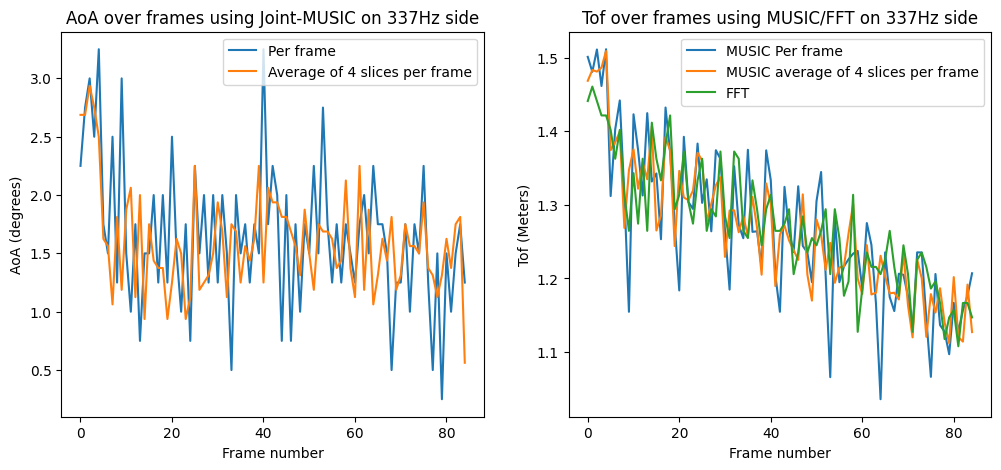

In [43]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
# plt.figure()
ax1.set_title("AoA over frames using Joint-MUSIC on " + str(f_tag) + "Hz side")
ax1.set_xlabel("Frame number")
ax1.set_ylabel("AoA (degrees)")
ax1.plot(resultAoA)
ax1.plot(resultAoA_avg)
ax1.legend(["Per frame", "Average of 4 slices per frame","FFT"])

ax2.set_title("Tof over frames using MUSIC/FFT on " + str(f_tag) + "Hz side")
ax2.set_xlabel("Frame number")
ax2.set_ylabel("Tof (Meters)")
ax2.plot(resultToF)
ax2.plot(resultToF_avg)
ax2.plot(resultToF_RP)
ax2.legend(["MUSIC Per frame", "MUSIC average of 4 slices per frame","FFT"])
plt.show()